# Dimensionality reduction through Linear Discriminant Analysis

Linear discriminant analysis can be stated as a dimensionality reduction task -- find a hyperplane plane such that points form different classes are maximally separated. The latter can be quantified in two principal ways:

* as a signal-to-noise ratio from signal-processing
* as a Bayesian factors from statistics

Both formalisations lead to the equivalent maximisation tasks. 
In this tutorial we do not consider technical details of LDA transformation rather we give a visual interpretation to it and explore the connections between LDA and PCA. 
Recall that PCA can be viewed as dimansionality reduction task with different objective -- find a hyperplane plane such that all points are maximally separated. 
These tasks are weakly connected a maximal separation between classes cannot bring all points together but on the same time it does not have to spread them appart inside the single class. 

For that we need a high-dimensional dataset with labels. 
We will use an image with different textures and colors such that a local texture is strongly connected with its color.
Now if we split the colour space into separate clusters we get the desired labels. 
The correspondence between the image points and local textures allows us to map LDA dimensions back to the pixels and use various color channels as way to show their values. As a result, you can interpret much clearly what do different LDA dimension characterise.    

Since the colorspace is inherently three dimensional we use package `ipyvolume` for making three dimensional plots interactive. Further details about his package can be obtained from

* [Ipyvolume documentation](https://ipyvolume.readthedocs.io/en/latest/)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Youtube](https://www.youtube.com/watch?v=hOKa8klJPyo)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Jupyter Notebook](https://github.com/maartenbreddels/talk-ipyvolume-scipy2018/blob/master/ipyvolume-presentation.ipynb)


We use several functions defined in [`common.py`](./common.py) to juggle between different image representations:

* luminocity decomosition
* conversions between standard RGB image and colorspace representation 

In [6]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

# Tools for 3D visualisation
import ipyvolume as ipv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

# Tools for LDA and PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Tools for clustering
from sklearn.cluster import KMeans

# Standard stuff
from pandas import Series
from pandas import DataFrame
from tqdm import tnrange#, tqdm_notebook
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Color-based classification of pixels 

We load the image and annotate each pixel with a color class.   

### Initial image

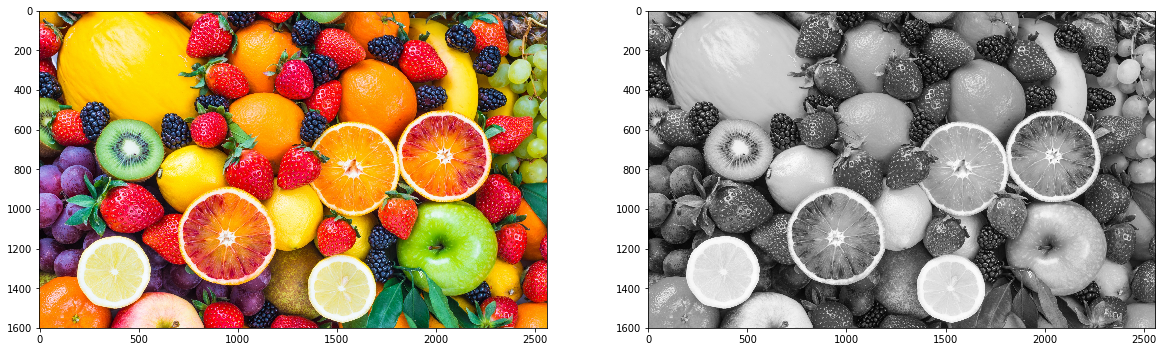

In [2]:
rgb_image = plt.imread('data/texture/colorful_fruits.png')
bw_image = convert_to_grayscale(rgb_image)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(bw_image, cmap='gray')

### Colorspace representation

In [30]:
full_cs = image_to_colorspace(rgb_image)
sample_cs = image_to_colorspace(rgb_image, sample_count=10000)

In [4]:
show_colorspace(sample_cs, clip=False)

### Luma decomposition

Luma decoposition adds `luma`, `rR`, `rG`, `rB` to the colorspace so that RGB information is decomposed into luminocity and chroma information. For simplicity the chroma information is store as as three dimensional vector `rR`, `rG`, `rB`. The corresponfing formula is

\begin{align*}
RGB = luma \cdot rRGB\enspace.
\end{align*}

In [31]:
full_cs = luma_decomposition(full_cs)
sample_cs = luma_decomposition(sample_cs)
display(head(full_cs))
show_colorspace(df[['rR', 'rG', 'rB']].rename(columns = {'rR': 'R', 'rG': 'G', 'rB': 'B'}))

,R,G,B,luma,rR,rG,rB
0,1.000000,0.768627,0.027451,0.753214,1.327644,1.020464,0.036445
1,1.000000,0.760784,0.019608,0.747716,1.337407,1.017478,0.026224
2,0.988235,0.752941,0.000000,0.737360,1.340235,1.021131,0.000000
3,0.976471,0.741176,0.000000,0.726938,1.343266,1.019587,0.000000
4,0.976471,0.749020,0.000000,0.731542,1.334812,1.023892,0.000000


### Colorspace clustering with kmeans algorithm

We will use a realively small sample to define color clusters and then extend corresponding labelling to the entire set of pixels

In [42]:
kmeans = KMeans(n_clusters=16).fit(sample_cs[['R', 'G', 'B']])
centers = DataFrame(kmeans.cluster_centers_, columns = ['R', 'G', 'B'])
full_cs = full_cs.assign(label = lambda df: kmeans.predict(df[['R', 'G', 'B']]))[['label', 'R', 'G', 'B', 'luma', 'rR', 'rG', 'rB']]
head(full_cs)

,label,R,G,B,luma,rR,rG,rB
0,13,1.000000,0.768627,0.027451,0.753214,1.327644,1.020464,0.036445
1,13,1.000000,0.760784,0.019608,0.747716,1.337407,1.017478,0.026224
2,13,0.988235,0.752941,0.000000,0.737360,1.340235,1.021131,0.000000
3,13,0.976471,0.741176,0.000000,0.726938,1.343266,1.019587,0.000000
4,13,0.976471,0.749020,0.000000,0.731542,1.334812,1.023892,0.000000


## II. Visual evaluation of clustering quality

* We first compute the mean chroma value for each cluster 
* Next we transfer the color classes to each pixel of a black and white image.
* After that we add croma value corresponding to the cluster lable to the black and white image.
* As the resulting data structure has now luma-chroma representation we can reconstruct the RGB representation.  

### Chroma values for each color cluster

In [43]:
chromas = (full_cs
           .groupby('label')
           .aggregate({'rR': np.mean, 'rG': np.mean, 'rB': np.mean})
           .reset_index())

display(chromas)

,label,rR,rG,rB
0,0,1.012117,1.144128,0.226973
1,1,1.050162,0.995040,0.894894
2,2,2.552508,0.359376,0.228961
3,3,1.220538,0.828470,1.305868
4,4,1.543027,0.906544,0.058316
5,5,1.299903,0.872066,0.873299
6,6,2.086831,0.513801,0.654779
7,7,1.152889,1.011219,0.542246
8,8,0.880680,1.122761,0.681617
9,9,2.943982,0.145491,0.303867


Visual comparison of cluster centers and chroma values. For clarity we schale the luminocity of chroma values to maximal intensity 

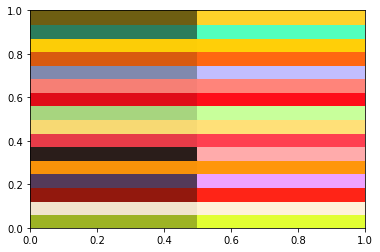

In [45]:
tmp = (chromas[['rR', 'rG', 'rB']]
       .assign(max = lambda df: df.apply(max, axis = 'columns'))
       .assign(rR = lambda df: df['rR']/df['max'])
       .assign(rG = lambda df: df['rG']/df['max'])
       .assign(rB = lambda df: df['rB']/df['max'])
       [['rR', 'rG', 'rB']]
      )

plt.figure()
currentAxis = plt.gca()
n = len(centers)
for i in range(n):
    currentAxis.add_patch(Rectangle((0,   i/n), 0.5, 1/n,alpha=1, color=centers.loc[i,:]))
    currentAxis.add_patch(Rectangle((0.5, i/n), 0.5, 1/n,alpha=1, color=tmp.loc[i,:]))
plt.show()

### Label transfer to black and white image pixels

As we merge the black and white dataframe with chroma values we need to store original order or it will be lost and we cannot get image back.

In [67]:
bw_cspace = (DataFrame(bw_image.flatten(), columns = ['luma'])
             .assign(i = lambda df: df.index.values)
             .assign(label = full_cs['label'])
             [['i', 'label', 'luma']])

head(bw_cspace)

,i,label,luma
0,0,13,0.753214
1,1,13,0.747716
2,2,13,0.737360
3,3,13,0.726938
4,4,13,0.731542


### Chroma transfer to black and white image pixels and image reconstruction

In [68]:
bw_cspace = pd.merge(bw_cspace, chromas, on = 'label').set_index('i').sort_index()
bw_cspace = rgb_reconstruction(bw_cspace)
head(bw_cspace)

,label,luma,rR,rG,rB,R,G,B
i,,,,,,,,
0,13,0.753214,1.28304,1.042461,0.040132,0.966403,0.785196,0.030228
1,13,0.747716,1.28304,1.042461,0.040132,0.959349,0.779464,0.030007
2,13,0.737360,1.28304,1.042461,0.040132,0.946062,0.768669,0.029591
3,13,0.726938,1.28304,1.042461,0.040132,0.932690,0.757804,0.029173
4,13,0.731542,1.28304,1.042461,0.040132,0.938597,0.762603,0.029358


### Visual validation of classification quality 

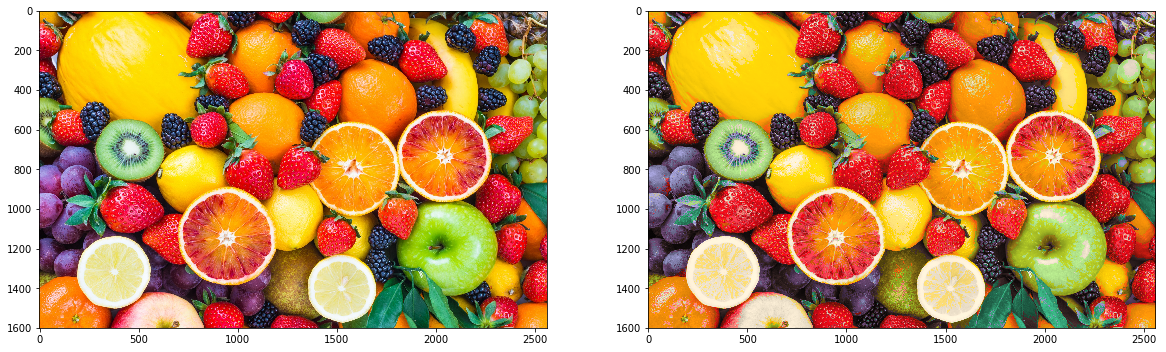

In [69]:
m, n = bw_image.shape
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(np.clip(colorspace_to_image(bw_cspace, m, n), 0,1))

## III. Preparations for linear discriminant analysis

Lets first fix the important paramaters about the image:
* image size $m\times n$
* texture window size $(2d+1)\times (2d+1)$
* size of the patch grid $k\times \ell$

In [70]:
d = 7
m, n = dim(bw_image)
k = int(m/(2 * d + 1))
l = int(n/(2 * d + 1))

### Grid of labels

Lets arrange the class labels for individual pixels into the $m\times n$ grid for simplicity. 

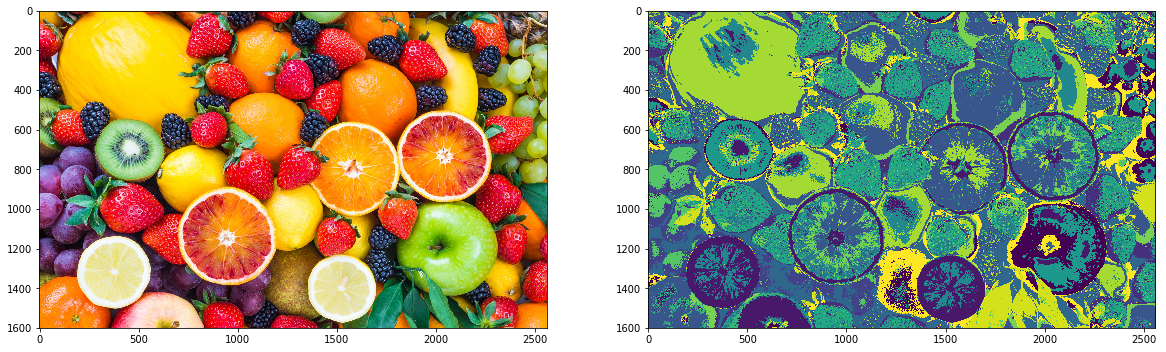

In [73]:
label_grid = bw_cspace['label'].values.reshape(m, n)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(label_grid)

### Extraction of texture windows with corresponding labels

For any coordinate $(x,y)$ we extract a $(2d+1)\times(2d+1)$ window centered in $(x,y)$ and having the label `label_grid[x,y]`.
For simplicity, we ignore all coordinates where one of the following conditions is satisfied:

\begin{align*}
&\begin{aligned}
x&< d\\
x&\geq m-d
\end{aligned}
&
&\begin{aligned}
y&< d\\
y&\geq n-d
\end{aligned}
\end{align*}


In [144]:
def extract_texture_vectors(bw_image: np.array, label_grid: np.array, x: np.array, y:np.array, m: int, n: int, d: int) -> DataFrame:
    
    index = (d <= x) & (x < m - d) & (d <= y) & (y < n - d)
    xm = x[index]
    ym = y[index]
    
    x0 = xm - d
    x1 = xm + d + 1
    y0 = ym - d
    y1 = ym + d + 1
    
    r = len(xm)
    texture_labels = np.empty([r])
    textures = np.empty([r, (2 * d + 1)**2])
    for i in range(r):
        texture_labels[i] = label_grid[xm[i], ym[i]]
        textures[i, :] = bw_image[x0[i]:x1[i], y0[i]:y1[i]].flatten()
        
    columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)]   
    return (DataFrame(textures, columns = columns)
            .assign(label = Series(texture_labels).astype(int))
            .assign(xm = Series(xm).astype(int))
            .assign(ym = Series(ym).astype(int))
            [['label', 'xm', 'ym'] + columns])

Simple test that the function works as expected.

In [145]:
d1 = 1
x =np.array([0,7,8, 1595])
y = x 
index = (d1 <= x) & (x < m - d1) & (d1 <= y) & (y < n - d)
tmp = extract_texture_vectors(bw_image, label_grid, x, y, m, n , d=d1)
mdisplay([DataFrame(label_grid[x[index],y[index]], columns=['label']), tmp, DataFrame(bw_image[x[index], y[index]], columns = ['luma'])], ['labels', 'textures', 'midpoints'])

labels textures midpoints 
 
 
 label 
 
 
 
 
 13 
 
 
 13 
 
 
 15 
 
 
 
 
 
 label 
 xm 
 ym 
 x01 
 x02 
 x03 
 x04 
 x05 
 x06 
 x07 
 x08 
 x09 
 
 
 
 
 13 
 7 
 7 
 0.744073 
 0.737402 
 0.737402 
 0.744073 
 0.741324 
 0.744073 
 0.725850 
 0.722376 
 0.725850 
 
 
 13 
 8 
 8 
 0.741324 
 0.744073 
 0.739916 
 0.722376 
 0.725850 
 0.734140 
 0.726297 
 0.726297 
 0.730708 
 
 
 15 
 1595 
 1595 
 0.295183 
 0.295183 
 0.293775 
 0.299104 
 0.289854 
 0.286827 
 0.291262 
 0.274169 
 0.267221 
 
 
 
 
 
 luma 
 
 
 
 
 0.741324 
 
 
 0.725850 
 
 
 0.289854

The actual extraction of random texture windows. With small probability returns replicas of the same window. 

In [146]:
d = 7
r = 5000
x = np.random.choice(range(d, m - d), size=r, replace = True)
y = np.random.choice(range(d, n - d), size=r, replace = True)
df = extract_texture_vectors(bw_image, label_grid, x, y, m, n , d)
head(df)

,label,xm,ym,x01,x02,x03,x04,x05,x06,x07,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
0,1,1446,460,0.882921,0.881024,0.885839,0.886969,0.882534,0.881253,0.886515,...,0.964011,0.964011,0.967932,0.967249,0.967249,0.968144,0.967249,0.967249,0.973026,0.973026
1,11,1229,167,0.457869,0.426500,0.443973,0.486380,0.496694,0.501509,0.517429,...,0.408580,0.434089,0.421069,0.375229,0.376680,0.399077,0.454209,0.430640,0.380794,0.400636
2,13,857,1565,0.811242,0.788996,0.788531,0.780351,0.758425,0.713656,0.696908,...,0.697586,0.694795,0.691321,0.694753,0.702595,0.687931,0.687931,0.691363,0.695967,0.699441
3,6,305,913,0.919531,0.870496,0.764329,0.631228,0.525515,0.473629,0.470471,...,0.462453,0.478717,0.518974,0.541117,0.526031,0.446883,0.423610,0.399974,0.392150,0.454586
4,5,438,1926,0.165292,0.093461,0.050649,0.055936,0.086049,0.113116,0.121237,...,0.027575,0.055918,0.085027,0.117654,0.141350,0.177855,0.208010,0.207859,0.196711,0.198517


## IV. Linear discriminant analysis

Now that we have extracted texture vectors with their locations and labels we can use `sklearn` to do linear discriminant analysis. 

In [162]:
lda = LinearDiscriminantAnalysis()
lda.fit(df.iloc[:, 3:], df['label'])
XI = df.iloc[:, :3].join(DataFrame(lda.transform(df.iloc[:, 3:]), columns = ['xi{:02d}'.format(i) for i in range(15)]))
display(head(XI))

,label,xm,ym,xi00,xi01,xi02,xi03,xi04,xi05,xi06,xi07,xi08,xi09,xi10,xi11,xi12,xi13,xi14
0,1,1446,460,-7.433074,-0.588380,-0.107725,-0.314741,0.222869,-0.120350,-0.412861,0.108178,0.118790,-0.213225,-0.027063,-0.108442,-0.173162,-0.140927,0.000198
1,11,1229,167,0.093170,0.591398,2.254880,2.250968,1.930313,-0.019060,-1.164954,0.200260,2.028870,1.946462,2.999105,-0.903920,-0.918205,2.288591,0.871783
2,13,857,1565,-3.316239,-0.608138,0.210088,-0.390810,0.113530,0.154859,-0.295198,0.260688,-0.135248,0.401971,-0.315635,-0.005510,-0.200966,-0.015260,-0.532939
3,6,305,913,1.296998,-0.232013,-0.370580,-1.270046,-0.754142,0.227087,-0.227400,-0.178785,-1.842379,-1.106891,-1.709391,0.209843,-0.481258,-1.883581,0.333077
4,5,438,1926,8.892921,-0.997582,0.414907,0.087682,0.494112,-0.757247,-1.177749,-0.112855,1.088460,1.970769,2.732818,0.030836,1.060470,1.982599,-2.118656


### Corresponding visualisation

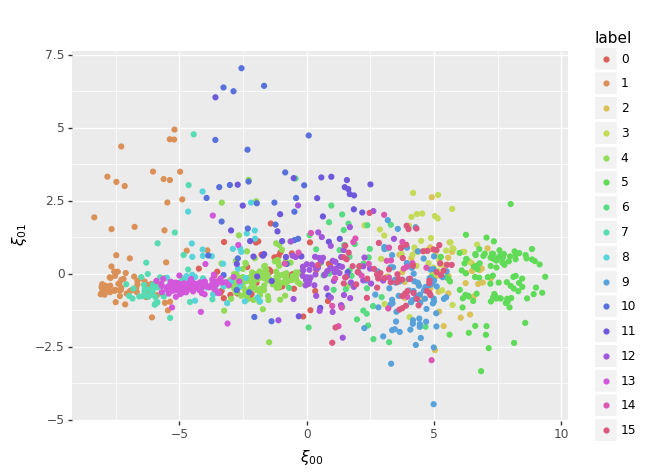

<ggplot: (7555948976)>

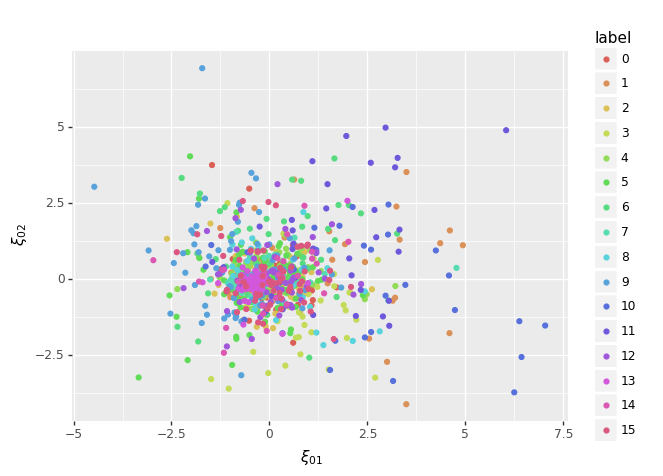

<ggplot: (-9223372029298820650)>

In [171]:
tmp = XI.sample(1000).assign(label = lambda df: df['label'].astype('category'))
p = ggplot(tmp)
p = p + geom_point(aes(x = 'xi00', y = 'xi01', color = 'label'))
p = p + scale_x_continuous(name = r'$\xi_{00}$')
p = p + scale_y_continuous(name = r'$\xi_{01}$')
display(p)
p = ggplot(tmp)
p = p + geom_point(aes(x = 'xi01', y = 'xi02', color = 'label'))
p = p + scale_x_continuous(name = r'$\xi_{01}$')
p = p + scale_y_continuous(name = r'$\xi_{02}$')
display(p)

### Projection directions as discriminative images

Let us first extract the matrix of orthogonal discriminative directions.

In [177]:
W_LDA = DataFrame(lda.coef_, columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)])
head(W_LDA)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
0,-2.383165,4.397575,-0.093827,0.681925,0.009361,2.875006,6.010115,-8.637619,3.890724,-0.855178,...,-3.332396,-3.590508,0.728392,-2.800178,1.708195,-1.291255,-3.744344,1.315134,-6.023129,4.240450
1,1.781416,10.252320,-9.271790,-1.588688,-7.756679,15.632799,-5.272313,-6.257182,4.589338,-6.679797,...,1.795635,-8.663831,3.990438,-0.770467,-4.610407,-7.392555,6.613918,-0.246999,-5.636659,2.628039
2,1.997541,-12.421886,7.037062,3.312890,3.499456,2.156381,-9.755816,10.904987,-10.286885,0.977307,...,4.093012,9.510033,-6.278758,-0.159876,7.898365,0.921567,-1.559209,-1.616747,3.767232,-0.174583
3,-7.493511,-5.485042,11.420909,-3.913285,7.531507,-14.763977,6.207030,3.480758,7.921599,-5.320431,...,6.827795,2.770049,1.410853,-5.871206,4.070680,7.762676,-12.178999,4.422600,7.199861,-3.999329
4,-0.957129,3.509498,-2.251178,0.257199,-2.770103,3.996842,-1.341915,-2.056028,2.026709,-1.167732,...,0.187824,-1.236866,0.890014,0.884660,-0.487224,0.684044,-1.071227,1.411142,-2.984259,1.334134


Reshape them back to texture masks in order to see what texture features are used to compute coordinates $\boldsymbol{\xi}$. 

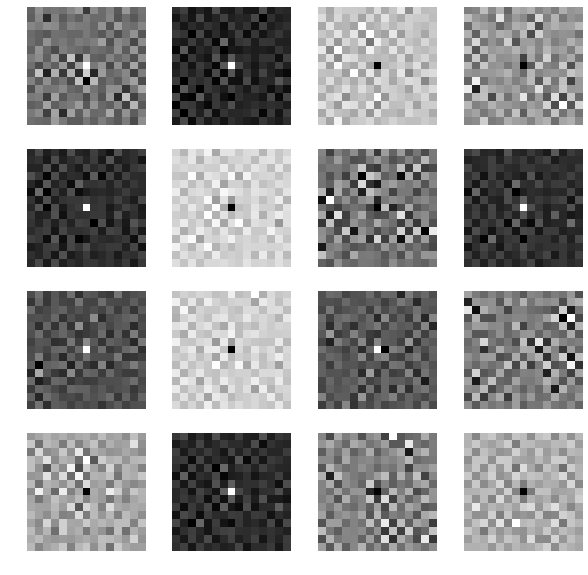

In [188]:
fig=plt.figure(figsize=(10,10))
for i in range(len(W_LDA)):
    fig.add_subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(W_LDA.iloc[i].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')

From this image it is clear that for most directions the pixel intensity of the original pixel has the largest impact.

### Variation covered by the projection vector of linear discriminant

In [190]:
from scipy.linalg import orth

In [199]:
P_LDA = DataFrame(orth(W_LDA.T), 
                  index = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)], 
                  columns = ['w{:02d}'.format(i) for i in range(15)]).T
head(P_LDA)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
w00,0.010024,0.075918,-0.048123,-0.008087,-0.049073,0.079731,-0.017181,-0.048886,0.036846,-0.024693,...,-0.010211,-0.035550,0.005302,0.014042,-0.046993,-0.016555,0.020837,-0.001479,-0.024185,0.009227
w01,0.058627,-0.033970,-0.038089,0.026097,-0.006722,0.003450,-0.010773,-0.042750,-0.005524,0.013077,...,-0.014534,0.045013,-0.044666,0.005879,0.003498,0.026352,-0.006648,-0.003749,-0.023620,-0.011460
w02,-0.007117,-0.011332,-0.017270,0.026331,-0.019261,0.002878,-0.047604,0.080943,-0.125857,0.117848,...,0.020952,-0.037361,0.014434,0.023414,0.006950,-0.043597,0.038988,0.020082,-0.054000,0.034355
w03,-0.018739,-0.002627,0.057050,-0.036351,0.003788,-0.098289,0.059772,-0.000375,-0.014232,0.110690,...,0.020875,-0.015211,0.021332,-0.062033,0.007654,0.033014,-0.011126,-0.017851,0.075304,-0.052825
w04,-0.033719,-0.015782,0.032159,-0.020891,0.024181,-0.053934,0.037911,-0.014570,0.060583,-0.019930,...,0.069425,-0.045300,0.024270,-0.020010,0.004296,0.021535,-0.056897,0.061872,-0.038718,0.020257


Lets compute orthogonal projection to the linear space spacified by LDA vectors. This shows how much variance LDA components can explain.

In [212]:
proj_LDA = P_LDA.T.dot(P_LDA.dot(df.iloc[:, 3:].T)).T
proj_other = df.iloc[:, 3:] - proj_LDA
head(proj_LDA)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
0,0.023310,0.057090,-0.033080,-0.001532,-0.059242,0.107917,-0.055971,-0.017053,0.015990,-0.027183,...,0.019934,-0.024172,-0.022740,0.084100,-0.061412,-0.011066,-0.001074,0.050322,-0.052796,0.025870
1,0.007515,0.035701,-0.024033,0.003267,-0.032547,0.061754,-0.039768,-0.004411,0.007378,-0.017456,...,0.005100,-0.005747,-0.010536,0.035752,-0.029255,-0.006758,0.001708,0.019506,-0.027451,0.012592
2,0.018891,0.043452,-0.026061,-0.000563,-0.044297,0.081684,-0.042880,-0.013054,0.012808,-0.021591,...,0.015728,-0.017964,-0.019814,0.067072,-0.048644,-0.006764,-0.001733,0.038996,-0.041022,0.020827
3,0.016058,0.025905,-0.013496,-0.002876,-0.029624,0.051526,-0.022500,-0.011400,0.009265,-0.012863,...,0.012868,-0.014781,-0.015021,0.051274,-0.035284,-0.001748,-0.003650,0.029716,-0.025610,0.013012
4,0.000663,0.004763,-0.007053,0.007609,0.003012,0.001744,-0.004499,0.001566,0.002076,-0.003710,...,-0.003911,0.002865,-0.007514,0.009308,-0.006999,0.003471,-0.002627,0.005295,-0.012677,0.010204


In [232]:
lda_var = np.var(proj_LDA).sum()
remaining_var = np.var(proj_other).sum()
total_var = np.var(df.iloc[:, 3:]).sum()

print('LDA variance:         {:.2f}%'.format(lda_var/total_var*100))
print('Unexplained variance {:.2f}%'.format(remaining_var/total_var*100))

LDA variance:         0.35%
Unexplained variance 99.65%


* The result clearly shows that LDA uses completely different directions than PCA and in fact most of the variance remains unexplained. 
* Thus subtle changes in the textures can lead to completely different LDA projections.

# Homework

## 5.1  Predictive power of LDA projection (<font color='red'>2p</font>)  

Use `LDA.predict` function to predict class labels from texture vectors $\boldsymbol{x}_i$. Compute the corresponding confusion matrix and accuracy. How much this result is better than random. Predict class labels directly  from LDA coordinates $\boldsymbol{\xi}$ by assigning the class which is closest to the class centers $(\bar{\boldsymbol{\xi}}_j)_{j=1}^{16}$. 

## 5.2. Visual interpretation of LDA directions  (<font color='red'>2p</font>) 

Compute LDA coordinates $\boldsymbol{\xi}$ for a reasonably sized subimages (e.g., $100\times 100$). Try to capture different textures and fruits.
You can use [`numpy.meshgrid`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) function to generate $(x,y)$ coordinates for the entire subimage. Use the existing LDA model to compute LDA coordinates for each pixel and add `luma` column. Now you have something that look like a luma-chroma colorspace, except you have more dimensions. You can now use some of them as substitutes of rRGB coordinates and thus you can use rgb reconstruction together with image reconstriction to see how LDA coordinates are spatially assigned and for which textures they are trigerred.    

**Extra point:** Use LDA predictions to recover the color instead of true labels. Interpret results (<font color='red'>**1p**</font>).  

## 5.3 More appropriate texture generation  (<font color='red'>3p</font>) 

The main problem with our apprach was very strong dependance on the exact pixel intensity. The aim of this exercise is to remove pixel intensity information. For that you need to center all textures $\boldsymbol{(x_{ij})}_{i,j=0}^{2d}$ so that the mean value $x_{00}+\ldots+x_{2d2d}=0$. 
Secondly you can compute the average standard deviation of all coordinates

\begin{align*}
\sigma=\sqrt{\frac{\mathbf{Var}[x_{00}]+\cdots+\mathbf{Var}[x_{2d2d}]}{(2d+1)^2}}
\end{align*}

and scale the textures so that $\sigma=1$. As a result, we have effecively removed all information about the actual pixel intensities and the resulting vectors describe texture in terms of intensity variation. Apply the entire analysis pipeline to get new LDA coordinates $\boldsymbol{\eta}$.
Visualise class separation among different directions and corresponding LDA texture masks.

**Extra points:**
* Estimate prediction precision from textures and from textures together with the pixel intensity. As usual map to the closest cluster. (<font 
color='red'>**1p**</font>) 
* Use LDA predictions to recover the color instead of true labels. Interpret results (<font color='red'>**1p**</font>). 
* Visualise projection coordinates $\boldsymbol{\eta}$ through RGB channels as in Exercise 5.2 (<font color='red'>**1p**</font>)

## 5.4 Targeted separation directions*  (<font color='red'>1p</font>) 

You define separating directions for subset of clusters. Pick cluster pairs that have clearly different texture and see if the corresponding LDA shape encodes textual patterns you would expect. You need to use texture vectors that do not contain intensity information to get sensible results. 